# Stock prediciton based on random walks using true random numbers

In order to estimate the variance and risk of a stock over time, the price deveolpment can be modelled by random walks. In the case of a symmetric walk, there is a 50% probability for either a growing or falling stpck price by a certain amount per day. By doing multiple repetitions of the simulation fpr a given period of time, one can estimate the variance of the stock. In order to ensure a true random walk, random numbers will be generated by a quantum computer. Like this, true randomness of the numbers making up the behaviour of the walk is ensured and no deterministically working classical algorithms contributes to the trend. True randomness of the input is also a desirable property for fields like encryption and communication.

In [1]:
import requests
import base64
import json

In [2]:
# define sample size, time frame and possible scenarios for the grow/fall rate of the stock
n_stocks = 20
n_days = 200
n_bits = 1

## Define input for service execution

In [3]:
n_numbers = n_stocks*n_days
backend_string = 'qasm_simulator'

data = {
    "n_numbers": n_numbers
}

params = {
    "n_bits": n_bits,
    "backend": backend_string
}

input_json = json.dumps({
    "data": data,
    "params": params
})

## Platform Service Execution

In order to be able to use the service via the platform, you must have an active application that is subscribed to the service. By doing so, you should see something like this:

<center>
    <img src="../images/app_view.jpg" width=80% alt="Application View with subscribed service">
</center >

Such an application holds all necessary information to authenticate to the service. By combining the consumer key and consumer secret an access token can be generated via the token endpoint (see `get_access_token`-method below). This access token (provided an active subscription to a service) allows for communication with the service, which is available via the service endpoint.

In [4]:
# url of the QRNG service, need to be subscribed to it, in order to use it
service_endpoint = 'https://gateway.am.platform.planqk.de/fd0a7648-6b0d-462c-aed2-26c46b439e1d/async-qrng/1.0.0'

In [5]:
# defined for an authorized application
consumer_key = 'e_VkvBOSHffK2OhnukW7Qh4BEksa'
consumer_secret = 'MmZrTY2cw3GNsKtfvb_gLkx3jG4a'
token_endpoint = 'https://gateway.am.platform.planqk.de/token'

### Generate Authentification token

Any generated access token is viable for 60 min and for every (successful) execution of the `get_access_token`-method a new access token is generated.

In [6]:
def get_access_token(consumer_key, consumer_secret, token_endpoint):
    """Generate token used for service authentification."""
    access_key = consumer_key + ":" + consumer_secret
    
    # encode the key in base64
    key_encoded = str(base64.b64encode(access_key.encode()).decode('ascii'))

    headers = {
        "Authorization": f"Basic {key_encoded}"
    }

    response = requests.post(token_endpoint,
                             headers=headers,
                             data="grant_type=client_credentials",
                             verify=True)

    if response.status_code != 200:
        print("Token call failed")
        print(response.status_code)
        return None

    print('Token call successful')
    
    return json.loads(response.content).get('access_token')

In [7]:
access_token = get_access_token(consumer_key,
                                consumer_secret,
                                token_endpoint)

# necessary http headers for following service requests
default_headers = {
    "Authorization": f"Bearer {access_token}",
    'Content-type': 'application/json'
}

Token call successful


### Sending request

In [26]:
# send requrest to server with input
post_response = requests.post(service_endpoint,
                              data=input_json,
                              headers=default_headers)
# id for the current execution 
if post_response.status_code in (200, 201):
    execution_id = post_response.json()['id']
    print(json.loads(post_response.content))
else:
    print(f'status code {post_response.status_code}')
    print('check whether your app is subscribed to the service.')

{'id': 'ebd36ad0-4b08-4962-96a2-76607c247852', 'status': 'PENDING', 'createdAt': '2022-04-26 13:25:27'}


In [27]:
# url for checking the status of the execution
status_url = service_endpoint + '/' + execution_id
status_url

'https://gateway.am.platform.planqk.de/fd0a7648-6b0d-462c-aed2-26c46b439e1d/async-qrng/1.0.0/ebd36ad0-4b08-4962-96a2-76607c247852'

In [28]:
# status-url also available via response header
post_response.headers['Location'] == status_url

True

### Check status

In [30]:
# check whether execution has finished
requests.get(url=status_url, 
             headers=default_headers).json()

{'id': 'ebd36ad0-4b08-4962-96a2-76607c247852',
 'status': 'SUCCEEDED',
 'createdAt': '2022-04-26 13:25:27'}

### Retrieve Result

In [31]:
result = requests.get(url=status_url + '/result',
                      headers=default_headers).json()

# list of n_numbers random numbers
rng_list = result['result']['random_number_list']
metadata = result['metadata']

## Post Processing

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [33]:
if n_bits == 1:
    # symmetric growth/shrink rates of 1%
    growth_rates = [0.01]
    shrink_rates = [0.01]
if n_bits == 2:
    # introduce different, yet equally likely rates
    growth_rates = [0.01, 0.02]
    shrink_rates = [0.005, 0.021]

half_range = 2**(n_bits-1)
whole_range = 2*half_range

if len(growth_rates) != half_range or len(shrink_rates) != half_range:
    print("## Rates do not match the chosen range.##")
    print("## Setting rates linear in 1% steps")
    growth_rates = [0.01*i for i in range(1, half_range+1)]
    shrink_rates = growth_rates.copy()
    
mean_rate = sum([pos_rate - neg_rate for pos_rate, neg_rate in zip(growth_rates, shrink_rates)])/(2*len(growth_rates))

In [34]:
start_price = 100.0

for i in range(n_stocks):
    start_idx = i * n_days
    end_idx = start_idx + n_days

    cf = pd.DataFrame({"rng": rng_list[start_idx:end_idx]})
    cf["factor"] = cf["rng"]
    
    for idx in range(half_range):
        cf.loc[cf["factor"] == idx, "factor"] = 1 - shrink_rates[idx]
        cf.loc[cf["factor"] == idx + half_range, "factor"] = 1 + growth_rates[idx]
    
    
    cf["factor"] = cf["factor"].cumprod()
    cf["price"] = start_price * cf["factor"]
    cf["stock"] = i
    cf["day"] = range(1, n_days + 1)

    if start_idx == 0:
        df = cf
    else:
        df = pd.concat([df, cf], axis = 0, ignore_index=False)
    df.reset_index(drop=True)

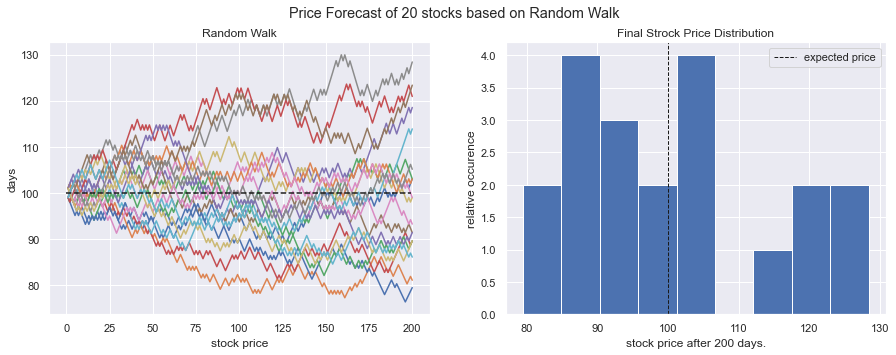

In [35]:
# Plot series
sns.set_theme()
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].set_xlabel("stock price")
ax[0].set_ylabel("days")
ax[0].set_title('Random Walk')

fig.suptitle(f"Price Forecast of {n_stocks} stocks based on Random Walk")

# random walk visualization
for i in range(n_days):
    sf = df[df["stock"] == i]
    ax[0].plot(sf["day"], sf["price"], "-", label='_nolegend_')
mean_prices = [start_price*(1+mean_rate)**day_idx for day_idx in range(n_days)]
ax[0].plot(range(n_days), mean_prices, "--k")

# final prices distribution
last_day_prices = df[df['day']==n_days]['price']
ax[1].hist(last_day_prices, bins=int((max(last_day_prices)-min(last_day_prices))//5))
ax[1].axvline(mean_prices[-1], color = 'k', linestyle = 'dashed', linewidth=1, label = '1')

ax[1].set_title(f"Final Strock Price Distribution")
ax[1].set_xlabel(f"stock price after {n_days} days.")
ax[1].set_ylabel(f"relative occurence")

ax[1].legend(["expected price"])

plt.show()